# Image Classification Model #

In [215]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
import sys
import os
path_to_src = os.path.join('../', 'src')
sys.path.insert(0, path_to_src)
from functions import *
%matplotlib inline

The following function will outut the graphical line graph of a model's performance on Recall, Precision, and Loss.

In [3]:
def visualize_training_results(history, iteration):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['recall_{}'.format(iteration)])
    ax1.plot(history.history['val_recall_{}'.format(iteration)])
    ax1.set_ylabel('Recall')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    ax3.plot(history.history['precision_{}'.format(iteration)])
    ax3.plot(history.history['val_precision_{}'.format(iteration)])
    ax3.set_ylabel('Precision')
    ax3.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()
    

### Splitting the data ###

In this dataset we have a training and testing directories. We will be using the testing directory as our holdout validation data (data we will use to validate out model), and the training directory as our main train/test data.

In [4]:
data_dir_train = '../data/train/'
data_dir_test = '../data/test/'
categories = ['NORMAL', 'PNEUMONIA']

Let's output one of the images of our training data.

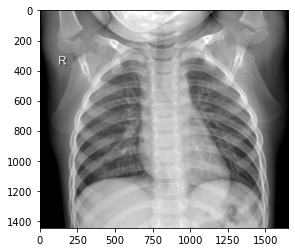

In [5]:
for category in categories:
    path_train = os.path.join(data_dir_train,category)
    for img in os.listdir(path_train):
        img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_train, cmap="gray")
        plt.show()
        break
    break

Now let's output one of our images from our testing (holdout data).

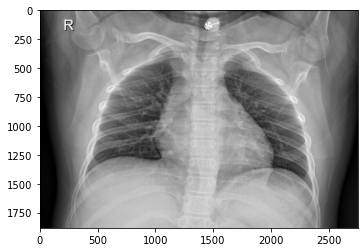

In [6]:
for category in categories:
    path_test = os.path.join(data_dir_test,category)
    for img in os.listdir(path_test):
        img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_test, cmap="gray")
        plt.show()
        break
    break

Let's see the img array shape

In [7]:
print(img_array_train.shape)
print(img_array_test.shape)

(1446, 1654)
(1882, 2752)


We don't want to bog down our model, therefore let's resize our image to a smaller resolution to provide efficiency and streamline the inputs into the model.

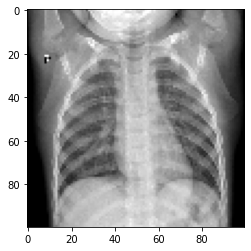

In [8]:
img_size = 100
train_array = cv2.resize(img_array_train,(img_size, img_size))
plt.imshow(train_array, cmap = 'gray')
plt.show()

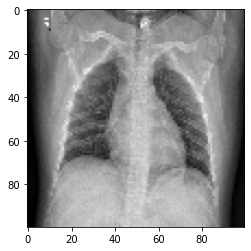

In [9]:
test_array = cv2.resize(img_array_test, (img_size, img_size))
plt.imshow(test_array, cmap = 'gray')
plt.show()

### Creating our datasets ###

In [10]:
train_data = []
test_data = []

Defining our functions to create our datasets for training and testing.

In [11]:
def create_training_data():
    for category in categories:
        path_train = os.path.join(data_dir_train,category)
        class_num = categories.index(category)
        for img in os.listdir(path_train):
            try:
                img_array_train = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
                train_array = cv2.resize(img_array_train,(img_size, img_size))
                train_data.append([train_array, class_num])
            except Exception as e:
                pass
            
            
def create_testing_data():
    for category in categories:
        path_test = os.path.join(data_dir_test,category)
        class_num = categories.index(category)
        for img in os.listdir(path_test):
            try:
                img_array_test = cv2.imread(os.path.join(path_test,img), cv2.IMREAD_GRAYSCALE)
                test_array = cv2.resize(img_array_test,(img_size, img_size))
                test_data.append([test_array, class_num])
            except Exception as e:
                pass

In [12]:
create_training_data()
create_testing_data()

Let's check the size length of the training and test data.

In [13]:
print('Training data count: {}'.format(len(train_data)))
print('Testing data count: {}'.format(len(test_data)))

Training data count: 5232
Testing data count: 624


In [14]:
random.shuffle(train_data)

In [15]:
random.shuffle(test_data)

Checking on the outputs of the labels per dataset.

In [16]:
for sample in train_data[:5]:
    print('Train', sample[1])
    
for sample in test_data[:5]:
    print('Testing', sample[1])

Train 1
Train 1
Train 1
Train 1
Train 0
Testing 1
Testing 0
Testing 1
Testing 0
Testing 0


Now it's time to split our data into its features and labels for both our training dataset and the testing (holdout) dataset.

In [17]:
X = []
y = []

In [18]:
Xtest = []
ytest = []

In [19]:
for features, label in train_data:
    X.append(features)
    y.append(label)

In [20]:
for features, label in test_data:
    Xtest.append(features)
    ytest.append(label)

Let's verify the that we don't have duplicates in our images. The following for loop should tell us which images are duplicates. If we have a significant amount of duplicates (5% or more) we will remove them from our dataset to prevent it from messing with our model's performance.

In [21]:
len(X)

5232

In [22]:
for idx, img in enumerate(X):
    for idx2, img2 in enumerate(X[idx+1:len(X)]):
        if np.array_equal(img, img2):
            print('duplicate found in: {}, {}'.format(idx, (idx + idx2 + 1)))

duplicate found in: 49, 3820
duplicate found in: 123, 781
duplicate found in: 445, 2065
duplicate found in: 465, 2645
duplicate found in: 730, 2620
duplicate found in: 733, 1382
duplicate found in: 759, 1512
duplicate found in: 780, 1184
duplicate found in: 984, 1716
duplicate found in: 1024, 2251
duplicate found in: 1100, 3302
duplicate found in: 1352, 5025
duplicate found in: 1367, 2012
duplicate found in: 1375, 2187
duplicate found in: 1375, 4838
duplicate found in: 1493, 1990
duplicate found in: 1493, 3979
duplicate found in: 1990, 3979
duplicate found in: 1996, 2722
duplicate found in: 2002, 4985
duplicate found in: 2115, 3464
duplicate found in: 2187, 4838
duplicate found in: 2273, 4180
duplicate found in: 2294, 4620
duplicate found in: 2311, 4650
duplicate found in: 2329, 4927
duplicate found in: 2377, 3817
duplicate found in: 3143, 3675


It appears that we have 28 duplicate images which is less than 5% of the dataset which is comprised of 5232 images.

Let's see if the images visually look the same.

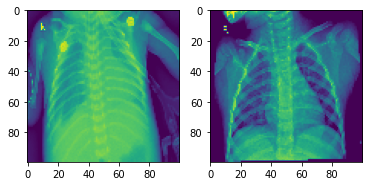

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(X[15])
ax2.imshow(X[1626])

These images visually look exactly the same. Since the it is a very tiny percentage of the overall dataset where we have duplicates we are not going to remove them.

### Reshaping our image arrays ###

In order for our models to take the data of all of our images we will stramline the size to 100,100,1.

In [24]:
X = np.expand_dims(X, axis=3)

In [25]:
X = X/255.0

In [26]:
X.shape

(5232, 100, 100, 1)

Let's do the same to our testing dataset.

In [27]:
Xtest = np.expand_dims(Xtest, axis=3)

In [28]:
Xtest = Xtest/255.0

In [29]:
Xtest.shape

(624, 100, 100, 1)

### Splitting our training dataset into our train and testing set ###

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=40)

In [31]:
X_train.shape

(3924, 100, 100, 1)

Let's encode our labels for the training and holdout dataset.

In [32]:
num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [33]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Encoding our testing/holdout dataset.

In [34]:
ytest = keras.utils.to_categorical(ytest, num_classes)

In [35]:
ytest = np.array(ytest)

Let's see the shape of our split data and the holdout dataset before we fit and evaluate our models.

In [36]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3924, 100, 100, 1)
(3924, 2)
(1308, 100, 100, 1)
(1308, 2)


In [37]:
print(Xtest.shape)
print(ytest.shape)

(624, 100, 100, 1)
(624, 2)


In [38]:
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (3924, 100, 100, 1)
3924 train samples
1308 test samples


# Baseline Model #

It's time to see how our first model performs. We will not add too many layers just the basics and see how it performs on our Recall.

In [39]:
base_line = Sequential()
base_line.add(Conv2D(32, kernel_size= 5, activation='relu', padding='same', input_shape=(100, 100, 1)))
base_line.add(MaxPooling2D(2,2))
base_line.add(Flatten())
base_line.add(Dense(16, activation='relu'))
base_line.add(Dense(2, activation='sigmoid'))

In [40]:
base_line.compile(loss="binary_crossentropy", optimizer="adam", metrics = [Precision(), Recall()])


In [41]:
base_line.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1280016   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 1,280,882
Trainable params: 1,280,882
Non-trainable params: 0
_________________________________________________________________


In [42]:
start = time.time()
history_baseline = base_line.fit(X_train,
                      y_train,
                      batch_size = 32,
                      epochs = 5,
                                validation_split = .25)
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 2943 samples, validate on 981 samples
Epoch 1/5
2943/2943 [==============================] - 13s 5ms/step - loss: 0.4446 - precision_1: 0.8186 - recall_1: 0.7407 - val_loss: 0.3347 - val_precision_1: 0.8062 - val_recall_1: 0.8267
Epoch 2/5
2943/2943 [==============================] - 14s 5ms/step - loss: 0.2927 - precision_1: 0.9249 - recall_1: 0.8957 - val_loss: 0.2565 - val_precision_1: 0.9416 - val_recall_1: 0.9541
Epoch 3/5
2943/2943 [==============================] - 14s 5ms/step - loss: 0.2477 - precision_1: 0.9458 - recall_1: 0.9317 - val_loss: 0.2516 - val_precision_1: 0.9180 - val_recall_1: 0.9358
Epoch 4/5
2943/2943 [==============================] - 14s 5ms/step - loss: 0.2198 - precision_1: 0.9552 - recall_1: 0.9490 - val_loss: 0.2191 - val_precision_1: 0.9684 - val_recall_1: 0.9694
Epoch 5/5
2943/2943 [==============================] - 14s 5ms/step - loss: 0.2088 - precision_1: 0.9600 - recall_1: 0.9541 - val_loss: 0.2050 - val_precision_1: 0.9593 - val_recall_1: 

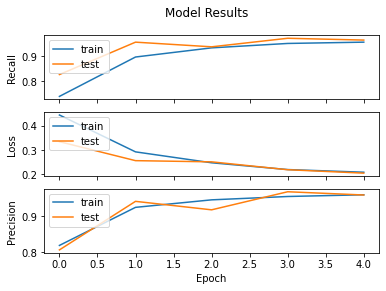

In [43]:
visualize_training_results(history_baseline,1)

In [44]:
results_train = base_line.evaluate(X_train, y_train)
results_test = base_line.evaluate(X_test, y_test)

1308/1308 [==============================] - 1s 684us/step


In [45]:
print("%s: %.2f%%" % (base_line.metrics_names[2], results_train[2]*100))
print("%s: %.2f%%" % (base_line.metrics_names[2], results_test[2]*100))

recall_1: 97.12%
recall_1: 95.80%


# Model 2 #

In [46]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_2.add(MaxPooling2D(4,4))
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dense(2, activation = 'sigmoid'))

In [47]:
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [48]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 100, 100, 64)      1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2560064   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 2,561,858
Trainable params: 2,561,858
Non-trainable params: 0
_________________________________________________________________


In [49]:
start = time.time()
history_model_2 = model_2.fit(X_train,
                              y_train,
                              batch_size = 32,
                              epochs = 5,
                              validation_data = (X_test,y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/5
3924/3924 [==============================] - 32s 8ms/step - loss: 0.2839 - precision_2: 0.8920 - recall_2: 0.8800 - val_loss: 0.1285 - val_precision_2: 0.9399 - val_recall_2: 0.9572
Epoch 2/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.1138 - precision_2: 0.9584 - recall_2: 0.9572 - val_loss: 0.0951 - val_precision_2: 0.9611 - val_recall_2: 0.9641
Epoch 3/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.1026 - precision_2: 0.9588 - recall_2: 0.9615 - val_loss: 0.1038 - val_precision_2: 0.9596 - val_recall_2: 0.9633
Epoch 4/5
3924/3924 [==============================] - 31s 8ms/step - loss: 0.0698 - precision_2: 0.9763 - recall_2: 0.9760 - val_loss: 0.0824 - val_precision_2: 0.9662 - val_recall_2: 0.9618
Epoch 5/5
3924/3924 [==============================] - 32s 8ms/step - loss: 0.0635 - precision_2: 0.9778 - recall_2: 0.9766 - val_loss: 0.1474 - val_precision_2: 0.9448 - val_recall_2:

In [50]:
results_train = model_2.evaluate(X_train, y_train)
results_test = model_2.evaluate(X_test, y_test)

1308/1308 [==============================] - 1s 1ms/step


In [51]:
print("Train %s: %.2f%%" % (model_2.metrics_names[2], results_train[2]*100))
print("Test %s: %.2f%%" % (model_2.metrics_names[2], results_test[2]*100))

Train recall_2: 95.59%
Test recall_2: 94.19%


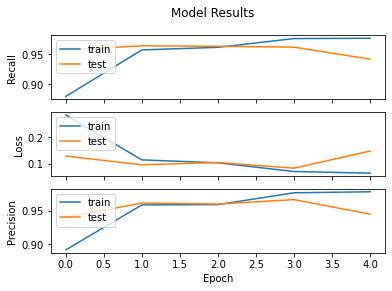

In [52]:
visualize_training_results(history_model_2, 2)

# Model 3 #

In [53]:
model_3 = Sequential()
model_3.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_3.add(Dense(64, activation = 'tanh'))
model_3.add(MaxPooling2D(4,4))
model_3.add(Flatten())
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dense(16, activation = 'sigmoid'))
model_3.add(Dense(2, activation = 'sigmoid'))

In [54]:
model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [55]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 128)     3328      
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100, 64)      8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1280032   
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                

In [56]:
start = time.time()
history_model_3 = model_3.fit(X_train,
                              y_train,
                              batch_size= 32,
                              epochs = 10,
                             validation_data = (X_test, y_test))

end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/10
3924/3924 [==============================] - 84s 21ms/step - loss: 0.3737 - precision_3: 0.8529 - recall_3: 0.8558 - val_loss: 0.2240 - val_precision_3: 0.9483 - val_recall_3: 0.9396
Epoch 2/10
3924/3924 [==============================] - 82s 21ms/step - loss: 0.2046 - precision_3: 0.9478 - recall_3: 0.9447 - val_loss: 0.1630 - val_precision_3: 0.9580 - val_recall_3: 0.9587
Epoch 3/10
3924/3924 [==============================] - 82s 21ms/step - loss: 0.1530 - precision_3: 0.9612 - recall_3: 0.9590 - val_loss: 0.1382 - val_precision_3: 0.9603 - val_recall_3: 0.9610
Epoch 4/10
3924/3924 [==============================] - 82s 21ms/step - loss: 0.1226 - precision_3: 0.9666 - recall_3: 0.9648 - val_loss: 0.1277 - val_precision_3: 0.9603 - val_recall_3: 0.9618
Epoch 5/10
3924/3924 [==============================] - 82s 21ms/step - loss: 0.1046 - precision_3: 0.9717 - recall_3: 0.9715 - val_loss: 0.1079 - val_precision_3: 0.9648 - val

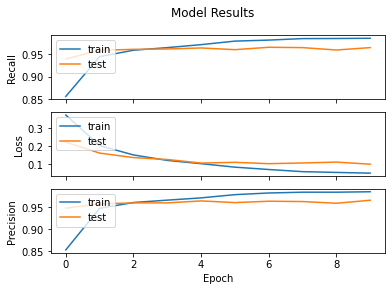

In [57]:
visualize_training_results(history_model_3, 3)

In [58]:
results_train = model_3.evaluate(X_train, y_train)
results_test = model_3.evaluate(X_test, y_test)

1308/1308 [==============================] - 6s 5ms/step


In [59]:
print("Train %s: %.2f%%" % (model_3.metrics_names[2], results_train[1]*100))
print("Test %s: %.2f%%" % (model_3.metrics_names[2], results_test[1]*100))

Train recall_3: 99.03%
Test recall_3: 96.63%


In [60]:
model_yaml = model_3.to_yaml()
with open("model_3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_3.save_weights("model_3.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
yaml_file = open('model_3.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_3.h5")
print("Loaded model from disk")

Loaded model from disk


In [62]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [63]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

624/624 [==============================] - 3s 6ms/step
------------------------------------
recall_4: 85.26%


# Model 4 #

In [64]:
model_4 = Sequential()
model_4.add(Conv2D(128, kernel_size = 5, activation = 'relu', padding = 'same', input_shape = (100,100,1)))
model_4.add(Dense(64, activation = 'tanh'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Conv2D(64, kernel_size = 4, activation = 'relu'))
model_4.add(MaxPooling2D(4,4))
model_4.add(Dropout(.20))
model_4.add(Flatten())
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Dense(16, activation = 'relu'))
model_4.add(Dense(8, activation = 'tanh'))
model_4.add(Dense(2, activation = 'sigmoid'))

In [65]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [66]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 128)     3328      
_________________________________________________________________
dense_9 (Dense)              (None, 100, 100, 64)      8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        65600     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)             

In [67]:
start = time.time()
history_model_4 = model_4.fit(X_train,
                              y_train,
                              batch_size = 64,
                              epochs = 15,
                              validation_data = (X_test, y_test))
end = time.time()
print('Minutes: {}'.format((end-start)/60))

Train on 3924 samples, validate on 1308 samples
Epoch 1/15
3924/3924 [==============================] - 85s 22ms/step - loss: 0.5805 - precision_5: 0.7311 - recall_5: 0.7095 - val_loss: 0.5044 - val_precision_5: 0.7515 - val_recall_5: 0.7515
Epoch 2/15
3924/3924 [==============================] - 82s 21ms/step - loss: 0.4312 - precision_5: 0.8567 - recall_5: 0.7087 - val_loss: 0.3420 - val_precision_5: 0.9529 - val_recall_5: 0.7118
Epoch 3/15
3924/3924 [==============================] - 82s 21ms/step - loss: 0.3476 - precision_5: 0.9379 - recall_5: 0.7041 - val_loss: 0.3058 - val_precision_5: 0.9791 - val_recall_5: 0.8937
Epoch 4/15
3924/3924 [==============================] - 82s 21ms/step - loss: 0.2842 - precision_5: 0.9524 - recall_5: 0.9177 - val_loss: 0.2500 - val_precision_5: 0.9577 - val_recall_5: 0.9526
Epoch 5/15
3924/3924 [==============================] - 82s 21ms/step - loss: 0.2420 - precision_5: 0.9511 - recall_5: 0.9457 - val_loss: 0.2201 - val_precision_5: 0.9557 - val

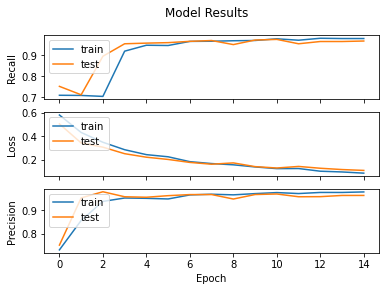

In [68]:
visualize_training_results(history_model_4, 5)

In [69]:
results_train = model_4.evaluate(X_train, y_train)
results_test = model_4.evaluate(X_test, y_test)

1308/1308 [==============================] - 8s 6ms/step


In [70]:
print("Train %s: %.2f%%" % (model_4.metrics_names[2], results_train[2]*100))
print("Test %s: %.2f%%" % (model_4.metrics_names[2], results_test[2]*100))

Train recall_5: 98.47%
Test recall_5: 96.56%


In [71]:
model_yaml = model_4.to_yaml()
with open("model_4.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_4.save_weights("model_4.h5")
print("Saved model to disk")

Saved model to disk


In [72]:
yaml_file = open('model_4.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_4.h5")
print("Loaded model from disk")

Loaded model from disk


In [73]:
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [Precision(), Recall()])

In [74]:
score = loaded_model.evaluate(Xtest, ytest)
print('------------------------------------')
print("%s: %.2f%%" % (loaded_model.metrics_names[2], score[2]*100))

624/624 [==============================] - 4s 7ms/step
------------------------------------
recall_6: 87.02%


# Model Explanation #

In [222]:
from keras.applications import inception_v3 as inc_net
from PIL import Image

In [225]:
image = Image.open(fp='../data/train/PNEUMONIA/BACTERIA-1008087-0001.jpeg')
new_image = image.resize((100, 100))

print(image.size) # Output: (1920, 1280)
print(new_image.size) # Output: (400, 400)

(1152, 1032)
(100, 100)


In [227]:
new_image = preprocessing.image.img_to_array(new_image)

In [232]:
new_image = np.expand_dims(new_image, axis=0)

In [233]:
new_image.shape

(1, 100, 100, 1)

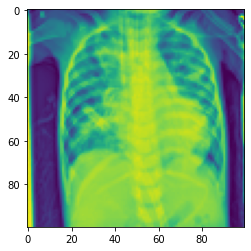

In [235]:
plt.imshow(new_image[0])

In [237]:
model_4.predict(new_image)

array([[0.021367 , 0.9785674]], dtype=float32)

[0.021367  0.9785674]


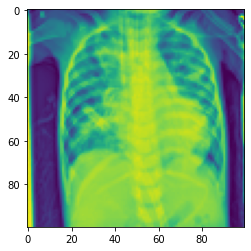

In [241]:
plt.imshow(new_image[0])
preds = model_4.predict(new_image)
for x in preds:
    print(x)

In [246]:
from lime import lime_image

In [247]:
explainer = lime_image.LimeImageExplainer()

In [252]:
explanation = explainer.explain_instance(new_image[0].astype('double'),
                                         model_4.predict, hide_color=0)

ValueError: Input array must have a shape == (..., 3)), got (100, 100, 1)